**Integrantes:** Fernando Salcedo Rentería, Rodrigo Ruíz Gutiérrez & Diego Valencia Cortés

# Optimización de la Dispersión en un Reactor Unidimensional mediante Enfriamiento Simulado

## 1. Descripción del Problema
Este proyecto aborda la simulación y optimización de un reactor químico tubular unidimensional.

### **Objetivo**
El objetivo principal es encontrar la velocidad de flujo óptima ($u$) que maximice la dispersión de un reactivo a lo largo del reactor en un tiempo determinado.

### **Modelo diferencial de difusión**
El transporte de masa en el reactor se modela mediante la ecuación de advección-difusión-reacción:

$$\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - u \frac{\partial C}{\partial x} - kC$$

Donde:
* $C(x,t)$: Concentración del reactivo.
* $D$: Coeficiente de difusión ($0.005 \, mm^2/s$).
* $u$: Velocidad de flujo ($mm/s$) [Variable de diseño].
* $k$: Constante de reacción de primer orden que se asumió ($0.1 \, s^{-1}$).

El reactor tiene una longitud $L=10 \, mm$ con una entrada de concentración constante en $x=0$ y una salida libre en $x=L$.

## 2. Metodología de Solución

### 2.1. Simulación Numérica
Para resolver la Ecuación Diferencial Parcial (EDP), utilizamos la librería `py-pde` (Zwicker, 2020), que implementa el método de las líneas y diferencias finitas para la discretización espacial.

### 2.2. Función Objetivo
Buscamos maximizar la "dispersión" o distribución del reactivo a lo largo del reactor, penalizando velocidades excesivamente altas que podrían requerir demasiada energía de bombeo. La función objetivo $E$ a maximizar se define como:

$$E(u) = w_1 \cdot \overline{C^2} - w_2 \cdot \frac{u^2}{2}$$

Donde $\overline{C^2}$ es el promedio de los cuadrados de la concentración en el estado final, y los pesos se han ajustado experimentalmente a $w_1=10.0$ y $w_2=0.5$.

### 2.3. Algoritmo de Optimización: Enfriamiento Simulado
Dado que la función objetivo puede presentar máximos locales y no linealidades, se utiliza el método de **Enfriamiento Simulado (Simulated Annealing)** (Kirkpatrick et al., 1983). Este algoritmo metaheurístico se inspira en el proceso de recocido de metales.

**Características clave de la implementación:**
* **Exploración Gaussiana:** La generación de nuevas soluciones candidatas ($u_{nuevo}$) se realiza perturbando la solución actual con un valor aleatorio extraído de una distribución normal: $u_{nuevo} = u_{actual} + \mathcal{N}(0, \sigma)$. Esto permite una exploración local fina y saltos ocasionales más grandes.
* **Criterio de Metropolis:** Para escapar de máximos locales, el algoritmo acepta soluciones peores con una probabilidad que depende de la "temperatura" del sistema ($T$) y la magnitud del empeoramiento ($\Delta E$):
  $$P(\text{aceptar}) = e^{\Delta E / T}$$
A altas temperaturas, el sistema acepta casi cualquier cambio (exploración), mientras que a bajas temperaturas se vuelve selectivo (explotación).

___
**$$Instalamos \; e \; importamos \; bibliotecas \; utlizadas \; para \; el \; proyecto.$$**
___

In [ ]:
# Instalamos en el kernel de ejecución la biblioteca para resolver EDPs obtenida con ejemplos de un GitHub
!pip install py-pde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Importamos las librerías requisito que se mencionan en la documentación de py-pde
import numba
import scipy
import sympy
import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Ahora si instalamos pde y algunas otras que nos serán de utilidad
import pde
import random
import math
import time

___
### Mostramos el modelo de solución (primera versión que se logró ejecutar) de la EDP y graficamos ejemplo con una $u$ aleatoriamente seleccionada (0.5)
___

In [ ]:
# Apoyándonos de Gemini, prooporcionandole el GitHub de soluciones definimos la función para resolver la EDP usando py-pde
def solve_reactor(u, D=0.005, k=0.1, L=10.0, t_max=10.0, dt=0.01, dx=0.1):
    """
    Parámetros:
    - u: Velocidad de flujo (mm/s) [VARIABLE A OPTIMIZAR]
    - D: Coeficiente de difusión (mm^2/s)
    - k: Tasa de reacción (asumida como 0.1, ya que no se especifica)
    - L: Longitud de la barra (mm)
    - t_max: Tiempo total a simular (s)
    Retorna:
    - storage: Objeto con el historial completo de la simulación (imágen de mapa de temperaturas)
    - final_field: El estado de la concentración al tiempo final (la solución que se buscaba)
    """

    # 1. Definimos la Malla (Grid) 1D
    # Rango [0, L], con pasos de dx. periodic=False es vital para fronteras fijas.
    grid = pde.CartesianGrid([[0, L]], [int(L/dx)], periodic=False)

    # 2. Estado Inicial
    # Asumimos que el reactor empieza con concentración 0 en todos lados
    initial_state = pde.ScalarField(grid, data=0.0)

    # 3. Condiciones de Frontera (Boundary Conditions)
    # Izquierda (x = 0): Entrada de material constante (Dirichlet). C = 1.0
    # Derecha (x = L): Salida libre (Neumann). Derivada=0 para permitir flujo de salida.
    bc_left = {"type": "value", "value": 1.0}
    bc_right = {"type": "derivative", "value": 0.0}

    # NOTA: Corrección de Gemini para la dimensionalidad del problema (reformulando los límites)
    # La forma correcta para 1D es una lista de los dos objetos de condición de frontera
    bcs = [bc_left, bc_right]

    # 4. Definimos la Ecuación Diferencial
    """ La sintaxis de py-pde usa strings con operadores:
    laplace(c) -> D*C_xx
    d_dx(c)    -> C_x
    c          -> C
    NOTA: El término advectivo (-u * d_dx(c)) es crucial dada la estructura de la EDP. """

    # pde pide formatos de string así que así se debe definir
    eq_str = f"{D} * laplace(c) - {u} * d_dx(c) - {k} * c"

    eq = pde.PDE({"c": eq_str}, bc=bcs)

    # 5. Resolvemos y guardamos el historial a lo largo de cada dt y dx
    # Usamos MemoryStorage para guardar los datos y poder graficar después
    storage = pde.MemoryStorage()

    # Ejecutamos el solver de optimize (Opt)
    # dt = 0.01. tracker=storage.tracker(0.1) guarda datos cada 0.1s
    result = eq.solve(initial_state, t_range=t_max, dt=dt, tracker=storage.tracker(0.1))

    return storage, result

In [ ]:
# Iniciamos la solución del ejemplo seleccionado
storage, final_state = solve_reactor(0.5)

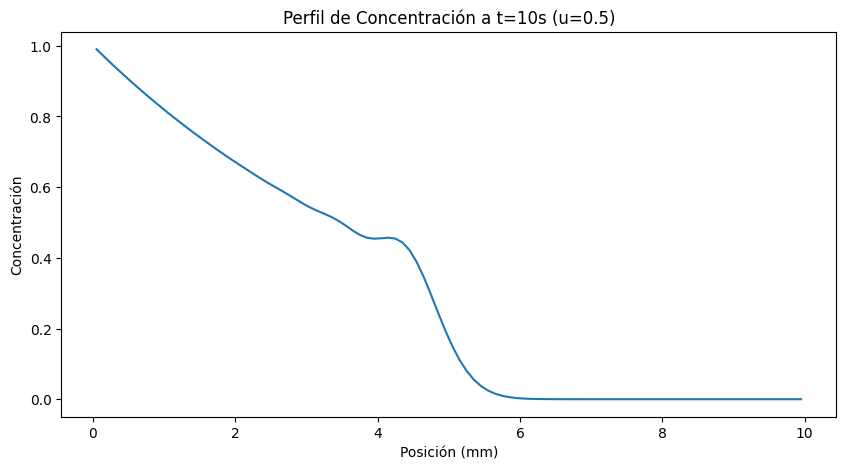

In [ ]:
# Graficamos el estado final calculado
fig, ax = plt.subplots(figsize=(10, 5))
final_state.plot(title=f"Perfil de Concentración a t=10s (u={0.5})", ax=ax)
ax.set_xlabel("Posición (mm)")
ax.set_ylabel("Concentración")
plt.show()

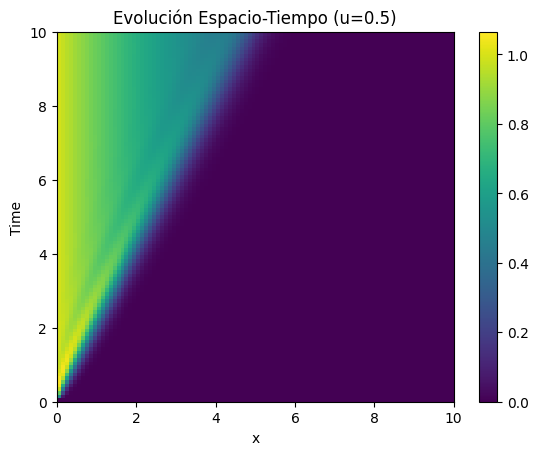

In [ ]:
# Ahora graficamos Evolución Espacio-Tiempo (Quimigrama)
pde.plot_kymograph(storage, title=f"Evolución Espacio-Tiempo (u={0.5})")

### Optimización del Código y Definición de la Búsqueda

**1. Método de Búsqueda:**
Se implementa el algoritmo de **Enfriamiento Simulado** (Simulated Annealing) para encontrar la velocidad de flujo óptima ($u$) evitando máximos locales.

**2. Función Objetivo ($E$):**
Siguiendo la sugerencia teórica, definimos la función a maximizar como un balance entre la distribución de concentración y la energía cinética del flujo:

$$E(u) = w_1 \cdot \overline{C^2} - w_2 \cdot \frac{u^2}{2}$$

  * **$\overline{C^2}$:** Promedio de concentraciones al cuadrado (maximizar dispersión).
  * **$\frac{u^2}{2}$:** Penalización por fricción/energía cinética (basada en la velocidad al cuadrado, factor típico en mecánica clásica para objetos en movimiento con consideración de la fricción del fluido).

___

In [ ]:
# Función optimizada para la EDP
def solve_reactor_fast(u, D=0.005, k=0.1, L=10.0, t_max=10.0, dt=0.01, dx=0.1):
    """
    Resuelve la EDP del reactor en MODO RÁPIDO (sin guardar historial).
    Se usa exclusivamente para optimización.
    """
    # 1. Malla 1D (Grid)
    grid = pde.CartesianGrid([[0, L]], [int(L/dx)], periodic=False)

    # 2. Estado Inicial (Concentración 0 en todo el tubo)
    initial_state = pde.ScalarField(grid, data=0.0)

    # 3. Condiciones de Frontera (Diccionarios explícitos para evitar errores)
    # x- (Entrada): Concentración fija = 1.0
    # x+ (Salida):  Flujo libre (derivada 0)
    field_bc = {"x-": {"value": 1.0}, "x+": {"derivative": 0.0}}

    # 4. Definición de la Ecuación Diferencial Parcial
    # Ecuación: dC/dt = D*Laplace(C) - u*Grad(C) - k*C
    eq_str = f"{D} * laplace(c) - {u} * d_dx(c) - {k} * c"
    eq = pde.PDE({"c": eq_str}, bc=field_bc)

    # 5. Resolver SIN tracker (Velocidad máxima, mínimo uso de RAM)
    result = eq.solve(initial_state, t_range=t_max, dt=dt, tracker=None)

    return result

In [ ]:
# Función NO optimizada (la anteriormente definida), para futuro uso en gráficas finales
def solve_reactor_visual(u, D=0.005, k=0.1, L=10.0, t_max=10.0, dt=0.01, dx=0.1):
    """
    Resuelve la EDP en MODO VISUAL (guardando historial).
    Se usa SOLO UNA VEZ al final para generar las gráficas.
    """
    grid = pde.CartesianGrid([[0, L]], [int(L/dx)], periodic=False)
    initial_state = pde.ScalarField(grid, data=0.0)
    field_bc = {"x-": {"value": 1.0}, "x+": {"derivative": 0.0}}

    eq_str = f"{D} * laplace(c) - {u} * d_dx(c) - {k} * c"
    eq = pde.PDE({"c": eq_str}, bc=field_bc)

    # Aquí sí usamos MemoryStorage para guardar la "película" de la simulación
    storage = pde.MemoryStorage()
    result = eq.solve(initial_state, t_range=t_max, dt=dt, tracker=storage.tracker(0.1))

    return storage, result

In [ ]:
# Función objetivo (recomendada por el profesor inicialmente)
def calcular_funcion_objetivo(final_field, u, w1=10.0, w2=0.5):
    """
    Calcula E = w1 * Promedio(C^2) - w2 * (u^2 / 2)
    Buscamos MAXIMIZAR este valor.
    """
    # Obtenemos los datos numéricos del campo
    data = final_field.data

    promedio_cuadrados = np.mean(data**2)
    termino_flujo = (u**2) / 2.0

    E = (w1 * promedio_cuadrados) - (w2 * termino_flujo)
    return E

In [ ]:
# Función puente que ejecuta la simulación rápida y califica el resultado.
def evaluar_solucion(u_candidato):
    # Aseguramos límites físicos antes de simular
    u_candidato = np.clip(u_candidato, 0.05, 0.9)

    # Corremos simulación rápida
    estado_final = solve_reactor_fast(u_candidato)

    # Calculamos E
    return calcular_funcion_objetivo(estado_final, u_candidato)

In [ ]:
# Función de pasos: genera un nuevo candidato vecino usando distribución normal.
def generar_vecino(u_actual, sigma=0.1, u_min=0.05, u_max=0.9):
    paso = random.gauss(0, sigma)
    u_nueva = u_actual + paso
    return np.clip(u_nueva, u_min, u_max)

## 3. Ejecución de la Optimización

A continuación, se ejecuta el algoritmo de Enfriamiento Simulado. Se ha configurado un esquema de enfriamiento geométrico

($T_{k+1} = \alpha T_k$) con $\alpha=0.80$ para asegurar una convergencia eficiente.

El bucle de optimización evalúa iterativamente diferentes velocidades de flujo, simulando el proceso físico en con rapidez y actualizando la mejor solución encontrada hasta el momento.

In [ ]:
# Párametros
T_INICIAL = 5.0
T_FINAL = 0.05 # Criterio de stop por temperatura
ALPHA_ENFRIAMIENTO = 0.85 # Factor de decaimiento (Velocidad de enfriamiento)
ITERACIONES_POR_TEMP = 3 # Intentos por cada nivel de temperatura

# Límites de la variable de control u (velocidad)
u_min, u_max = 0.05, 0.9

# 1. Estado Inicial Aleatorio
u_actual = random.uniform(u_min, u_max)
print(f"Calculando estado inicial (u={u_actual:.4f})...")
E_actual = evaluar_solucion(u_actual)

# Historiales para graficar
hist_E = [E_actual]
hist_u = [u_actual]

best_u = u_actual
best_E = E_actual

print(f"\n--- INICIANDO OPTIMIZACIÓN (Enfriamiento Simulado) ---")
print(f"Objetivo: Maximizar E buscando u en [{u_min}, {u_max}]")
start_time = time.time()

# Temperatura actual
T = T_INICIAL
step = 0

# Bucle WHILE: enfriamiento simulado
while T > T_FINAL:
    step += 1

    # Bucle interno: equilibrio térmico en cada temperatura
    for _ in range(ITERACIONES_POR_TEMP):

        # A. Generar vecino
        u_vecino = generar_vecino(u_actual, sigma=0.08, u_min=u_min, u_max=u_max)

        # B. Evaluar vecino
        E_vecino = evaluar_solucion(u_vecino)

        # C. Calcular Delta (Maximizar E)
        delta_E = E_vecino - E_actual

        # D. Criterio de Aceptación (Metropolis)
        aceptar = False
        if delta_E > 0:
            # Si mejora, aceptamos siempre
            aceptar = True
        else:
            # Si empeora, aceptamos con probabilidad prob = exp(delta / T)
            # Evitamos overflow si T es muy pequeño
            if T > 1e-5:
                prob = math.exp(delta_E / T)
                if random.random() < prob:
                    aceptar = True
            else:
                aceptar = False

        # E. Actualizar estado
        if aceptar:
            u_actual = u_vecino
            E_actual = E_vecino

            # Actualizar el mejor histórico
            if E_actual > best_E:
                best_E = E_actual
                best_u = u_actual

        # Guardar datos
        hist_E.append(E_actual)
        hist_u.append(u_actual)

    # F. Enfriar temperatura (Schedule Geométrico)
    T = T * ALPHA_ENFRIAMIENTO

    # Barra de progreso simple en texto
    if step % 5 == 0:
        print(f"Paso {step:03d} | T={T:.4f} | Mejor u={best_u:.4f} | Mejor E={best_E:.4f}")

total_time = time.time() - start_time
print(f"\n OPTIMIZACIÓN COMPLETADA en {total_time:.2f} segundos.")
print(f"RESULTADO ÓPTIMO -> Velocidad u: {best_u:.5f} mm/s")
print(f"RESULTADO ÓPTIMO -> Dispersión E: {best_E:.5f}")

Calculando estado inicial (u=0.4449)...

--- INICIANDO OPTIMIZACIÓN (Enfriamiento Simulado) ---
Objetivo: Maximizar E buscando u en [0.05, 0.9]
Paso 005 | T=2.2185 | Mejor u=0.7594 | Mejor E=3.1262
Paso 010 | T=0.9844 | Mejor u=0.9000 | Mejor E=3.6797
Paso 015 | T=0.4368 | Mejor u=0.9000 | Mejor E=3.6797
Paso 020 | T=0.1938 | Mejor u=0.9000 | Mejor E=3.6797
Paso 025 | T=0.0860 | Mejor u=0.9000 | Mejor E=3.6797

 OPTIMIZACIÓN COMPLETADA en 966.78 segundos.
RESULTADO ÓPTIMO -> Velocidad u: 0.90000 mm/s
RESULTADO ÓPTIMO -> Dispersión E: 3.67967


## 4. Resultados y Discusión

Las gráficas a continuación muestran:
1.  **Evolución de la Función Objetivo ($E$):** Se observa cómo el valor de $E$ tiende a aumentar a medida que avanza la optimización, estabilizándose hacia el final. Las fluctuaciones iniciales corresponden a la fase de alta temperatura donde se aceptan soluciones subóptimas para explorar el espacio de búsqueda.
2.  **Búsqueda de la Velocidad ($u$):** Muestra la trayectoria de la variable de decisión. La convergencia hacia un valor específico indica la robustez del óptimo encontrado.
3.  **Perfil de Concentración Óptimo:** Representa la distribución final del reactivo en el reactor ($t=10s$) utilizando la velocidad óptima encontrada.
4.  **Quimigrama (Espacio-Tiempo):** Visualiza la evolución completa de la concentración a lo largo del tiempo y el espacio para la configuración óptima.

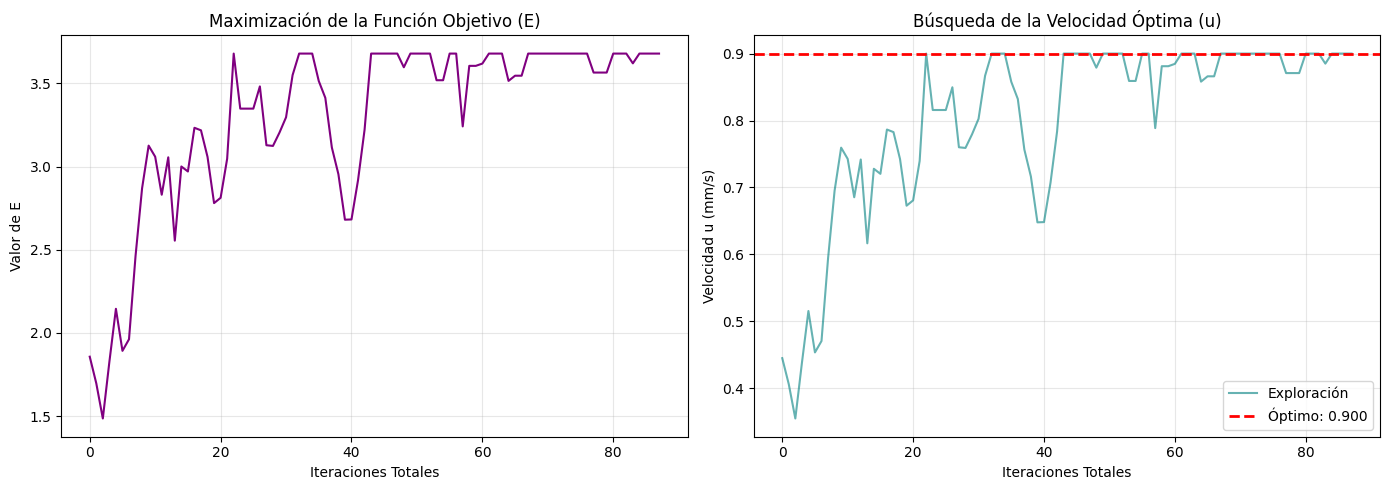

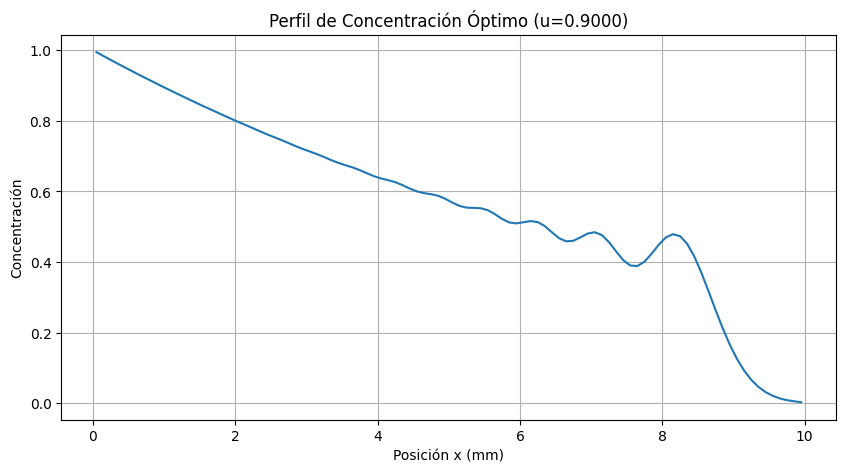

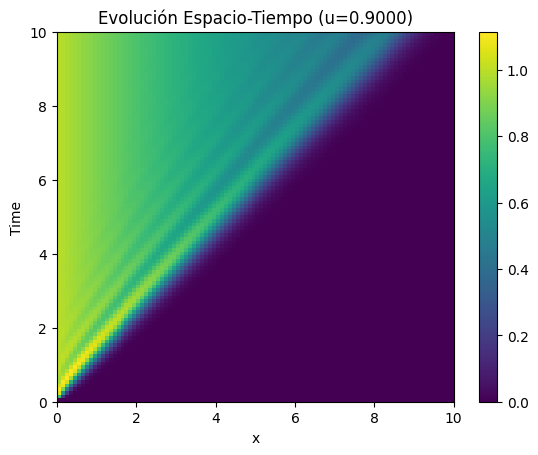

In [ ]:
# Graficamos los resultados

# Figura 1: Convergencia del Algoritmo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Evolución de la Función Objetivo
ax1.plot(hist_E, color='purple', linewidth=1.5)
ax1.set_title("Maximización de la Función Objetivo (E)")
ax1.set_xlabel("Iteraciones Totales")
ax1.set_ylabel("Valor de E")
ax1.grid(True, alpha=0.3)

# Exploración de la variable u
ax2.plot(hist_u, color='teal', alpha=0.6, label='Exploración')
ax2.axhline(best_u, color='red', linestyle='--', linewidth=2, label=f'Óptimo: {best_u:.3f}')
ax2.set_title("Búsqueda de la Velocidad Óptima (u)")
ax2.set_xlabel("Iteraciones Totales")
ax2.set_ylabel("Velocidad u (mm/s)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figura 2: Simulamos la solución óptima para graficarla.
storage_opt, final_opt = solve_reactor_visual(best_u)

fig_res, ax_res = plt.subplots(figsize=(10, 5))
final_opt.plot(title=f"Perfil de Concentración Óptimo (u={best_u:.4f})", ax=ax_res)
ax_res.set_xlabel("Posición x (mm)")
ax_res.set_ylabel("Concentración")
ax_res.grid(True)
plt.show()

# Figura 3: Evolución de la gráfica u = 0.9 contra tiempo - Mapa de Calor (Quimigrama)
pde.plot_kymograph(storage_opt, title=f"Evolución Espacio-Tiempo (u={best_u:.4f})")

## 5. Conclusiones

Las gráficas mostraron distintas cosas:
1.  **Evolución de la Función Objetivo ($E$):** Se observa cómo el valor de $E$ tiende a aumentar de manera simultánea a la velocidad (lo cual tiene sentido, más velocidad, entonces, más energía).
2.  **Búsqueda de la Velocidad ($u$):** Resulta en un valor de $u = 0.9$, lo cual también tiene sentido físico, ya que mayor rapidez de difusión, pues lógicamente habrá también una maximización del flujo (al menos en 1D donde no se consideran fenómenos de mecánica de fluidos).
4.  **Quimigrama (Espacio-Tiempo):** Visualiza la evolución completa de la concentración a lo largo del tiempo y el espacio para la configuración óptima.

## 6. Referencias

* Google. (2025). *Gemini 3.0 PRO* [Large language model]. https://gemini.google.com/
* Kirkpatrick, S., Gelatt, C. D., & Vecchi, M. P. (1983). Optimization by Simulated Annealing. *Science*, 220(4598), 671–680. https://doi.org/10.1126/science.220.4598.671
* Zwicker, D. (2020). py-pde: A Python package for solving partial differential equations. *Journal of Open Source Software*, 5(48), 2158. https://doi.org/10.21105/joss.02158
* Zwicker Group. (s.f.). *py-pde: Python package for solving partial differential equations*. GitHub. https://github.com/zwicker-group/py-pde

___
### **Anexo:**
A lo largo del desarrollo de este proyecto, se usaron herraminetas de IA, dada la complejidad del problema y limitante del tiempo para aprender la sintaxis de distitintas funciones dentro de la biblioteca para la solución de ecuaciones diferenciales parciales (el uso fue sobre todo para el modelado, dado que la biblioteca tenía como limitante que está hecha para modelar figuras 2D y no 1D), además, la búsqueda de la biblioteca `py-pde` se realizó dentro de GitHub (tomando como idea inicial métodos numéricos apredidos durante un curso de Ecuaciones diferenciales parciales aplicadas).
___